In [9]:
import pickle
pickle_in = open("dataset_pickle\X.pickle","rb")
X = pickle.load(pickle_in)

X = X/255.0

pickle_in = open("dataset_pickle\y.pickle","rb")
y = pickle.load(pickle_in)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [11]:
#Setup Distrbuited training
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())   #Enables

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from sklearn.model_selection import StratifiedKFold #for K-fold cross validation
import numpy

tf.random.set_seed(42)

Resolution = 100

# numpy.random.seed(7)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []

#for train, test in kfold.split(X, y):

with strategy.scope():      #Enables multi-gpu
    model = Sequential([
        
        Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu', input_shape=(Resolution, Resolution, 1)),
        MaxPooling2D(pool_size=(1, 5), strides=(4)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 4), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 2), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 2), strides=(2)),
        
        Flatten(),
        #Dense(32, activation='relu'),

        Dense(6, activation='softmax')
    ])


model.summary()

model.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizers.Adam(learning_rate=0.001),                  #gradient descent
            metrics=['accuracy'])
            

lr_change = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.000)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='min')
callbacks = [lr_change,early_stopping]
    #scores = model.evaluate(X[test], y[test], verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #cvscores.append(scores[1] * 100)
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))    

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 25, 24, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 25, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 13, 11, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 7, 5, 32)          0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 7, 5, 32)         

In [26]:
history = model.fit(X, y, batch_size=16, epochs=200, validation_split=0.2,callbacks=callbacks)
#history = model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test,y_test),callbacks=callbacks)

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
60/60 [==============================] - 3s 17ms/step - loss: 1.7951 - accuracy: 0.1311 - val_loss: 1.7922 - val_accuracy: 0.1375
Epoch 2/200
60/60 [==============================] - 1s 13ms/step - loss: 1.7909 - accuracy: 0.1833 - val_loss: 1.7795 - val_accuracy: 0.1875
Epoch 3/200
60/60 [==============================] - 1s 13ms/step - loss: 1.7133 - accuracy: 0.2640 - val_loss: 1.4082 - val_accuracy: 0.4333
Epoch 4/200
60/60 [==============================] - 1s 13ms/step - loss: 1.3640 - accuracy: 0.4065 - val_loss: 1.3063 - val_accuracy: 0.3500
Epoch 5/200
60/60 [==============================] - 1s 14ms/step - loss: 1.3139 - accuracy: 0.4236 - val_loss: 1.1515 - val_accuracy: 0.4792
Epoch 6/200
60/60 [==============================] - 1s 15ms/step - loss: 1.0513 - accuracy:

38/38 - 1s - loss: 0.1182 - accuracy: 0.9550
38/38 [==============================] - 0s 7ms/step - loss: 0.1182 - accuracy: 0.9550


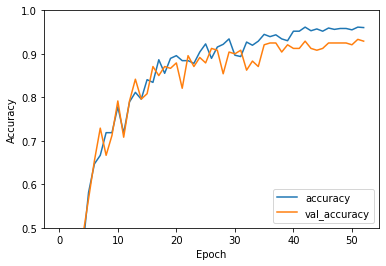

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X,  y, verbose=2)
preds = model.evaluate(X, y,verbose=1, sample_weight=None)

In [102]:
model.save("models\model_habd2.h5")
print("model saved")

model saved


In [24]:
from keras.models import load_model
# load model
model = load_model('models\model_habd.h5')
# summarize model.
#model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 25, 24, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 11, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 5, 32)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 5, 32)         

In [28]:
# evaluate the model
import pickle
pickle_in = open("dataset_pickle\X_user.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_user.pickle","rb")
y_test = pickle.load(pickle_in)

X_test = X_test/255.0

score = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

8/8 - 0s - loss: 1.0202 - accuracy: 0.7167
accuracy: 71.67%


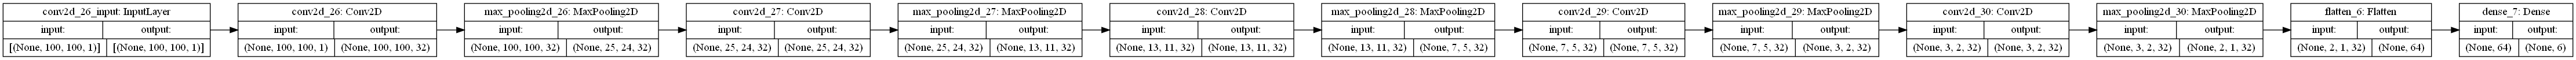

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,rankdir='LR')

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
y_pred = model.predict(X_test)
rounded_labels=np.argmax(y_pred, axis=1)
print(rounded_labels.shape)
confusion = confusion_matrix(y_test, rounded_labels)

(240,)


In [106]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[19 15  0  0  2  4]
 [ 1 37  0  0  2  0]
 [ 0  0 39  0  0  1]
 [ 0  2  0 37  1  0]
 [ 0  0  0  0 40  0]
 [ 3 12  0  0 17  8]]


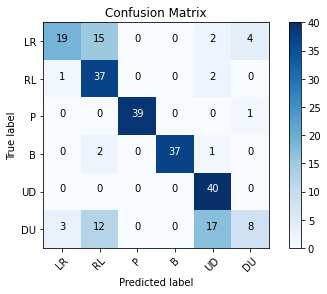

In [107]:
import itertools
Classes = ["LR", "RL", "P", "B", "UD", "DU"]
plot_confusion_matrix(cm=confusion,title='Confusion Matrix', classes=Classes)
#plot.savefig('plot_confusion_matrix.png')